# Let´s do some explorations on different optimization use cases

Ressources: https://towardsdatascience.com/how-to-develop-optimization-models-in-python-1a03ef72f5b4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pulp
from pulp import *

## Use Case 1:
- A bakery makes cakes and pies every day. 
- It can make a total of 30 items in one day, which at least must be 5 cakes and 10 pies for its planned customers. 
- The profit on each cake is $1.5 and the profit on each pie is $2.00. 
- How many cakes and pies should be made to maximize the profit?

### Solution Approach #1: Monte-Carlo Simulation using Random Search

In [2]:
cakes = []
pies = []
profits = []
n = 1000
# loop over random number of cakes between 0<= c <=30
for _ in range(n):
    c = int(np.random.uniform(low=0, high=30, size=1)) 
    # loop over random number of pies between 0<= p <=30
    for _ in range(n):
        p = int(np.random.uniform(low=0, high=30, size=1))
        # check boundary conditions
        if c + p <= 30 and c>=5 and p>=10:
            profit = 1.5*c + 2.0*p
            cakes.append(c)
            pies.append(p)
            profits.append(profit)

# make dataframe
d = {'cakes': cakes, 'pies': pies, 'profit': profits}
mcs_results = pd.DataFrame(data=d)
# drop duplicates
mcs_results = mcs_results.drop_duplicates()
# sort by profits
mcs_results = mcs_results.sort_values(by='profit', ascending=False) 
# find best parameters to optimize profit
p_opt = int(mcs_results.iloc[0,:].pies)
c_opt  = int(mcs_results.iloc[0,:].cakes)
profit_max = mcs_results.iloc[0,:].profit
print('The bakery should bake {} pies and {} cakes to maximize profit of {} $'.format(p_opt, c_opt, profit_max))         

The bakery should bake 25 pies and 5 cakes to maximize profit of 57.5 $


In [3]:
# find maximum profit
mcs_results.head(5)

,cakes,pies,profit
3404,5,25,57.5
765,6,24,57.0
7130,7,23,56.5
1245,8,22,56.0
3428,5,24,55.5


In [4]:
fig = px.histogram(mcs_results, x='profit')
fig.update_layout(width=500,height=500)
fig.show()

In [5]:
mcs_results_mat = mcs_results.pivot(index='cakes', columns='pies')['profit'].fillna(0)
mcs_results_mat

pies,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
cakes,,,,,,,,,,,,,,,,
5,27.5,29.5,31.5,33.5,35.5,37.5,39.5,41.5,43.5,45.5,47.5,49.5,51.5,53.5,55.5,57.5
6,29.0,31.0,33.0,35.0,37.0,39.0,41.0,43.0,45.0,47.0,49.0,51.0,53.0,55.0,57.0,0.0
7,30.5,32.5,34.5,36.5,38.5,40.5,42.5,44.5,46.5,48.5,50.5,52.5,54.5,56.5,0.0,0.0
8,32.0,34.0,36.0,38.0,40.0,42.0,44.0,46.0,48.0,50.0,52.0,54.0,56.0,0.0,0.0,0.0
9,33.5,35.5,37.5,39.5,41.5,43.5,45.5,47.5,49.5,51.5,53.5,55.5,0.0,0.0,0.0,0.0
10,35.0,37.0,39.0,41.0,43.0,45.0,47.0,49.0,51.0,53.0,55.0,0.0,0.0,0.0,0.0,0.0
11,36.5,38.5,40.5,42.5,44.5,46.5,48.5,50.5,52.5,54.5,0.0,0.0,0.0,0.0,0.0,0.0
12,38.0,40.0,42.0,44.0,46.0,48.0,50.0,52.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,39.5,41.5,43.5,45.5,47.5,49.5,51.5,53.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
fig = px.imshow(mcs_results_mat, x=mcs_results_mat.columns, y=mcs_results_mat.index)
fig.update_layout(width=500,height=500)
fig.show()

### Solution Approach #2: Linear Optimization using PuLP

In [7]:
model = LpProblem('Maximize Bakery Profits', sense= LpMaximize)

c:\Users\Nutzer\.conda\envs\optimization_env\lib\site-packages\pulp\pulp.py:1352: UserWarning:

Spaces are not permitted in the name. Converted to '_'



In [8]:
# define decision variables
c = LpVariable('C', lowBound=0, upBound=None, cat='Integer')
p = LpVariable('P', lowBound=0, upBound=None, cat='Integer')

In [9]:
# define constraints
model += c + p <= 30 # at least 30 items
model += c >= 5 # at least 5 cakes
model += p >= 10 # at least 10 pies

In [10]:
# define objective function
model += 1.5 * c + 2.0 * p

In [11]:
# solve model
print('solve model...')
print('model status: ', LpStatus[model.status])
model.solve()
print('model status: ', LpStatus[model.status])
print('optimized number of cakes: ', int(c.varValue))
print('optimized number of pies: ', int(p.varValue))
print('maximized price: ', value(model.objective))

solve model...
model status:  Not Solved
model status:  Optimal
optimized number of cakes:  5
optimized number of pies:  25
maximized price:  57.5


## Use Case 2:
- A post office is looking to hire postman, with the requirements to work 5 consecutive days and then 2 days off. 
- The estimated least number of postmen needed for each day of the week is: Monday: 25, Tuesday: 32, Wednesday: 22, Thursday: 18, Friday: 24, Saturday: 12, Sunday: 14
- The objective is to hire the minimum number of workers

To solve this problem, we need to write down the constraints in terms of the number of workers we need to start working on each day such as; x_0 is the number of workers starting to work on Monday, x_1 is the number of workers starting to work on Tuesday, etc. By doing so, we can store x_0 from Monday to Friday and x_1 from Tuesday to Saturday since they need to work 5 consecutive days

### Solution Approach #1: Monte-Carlo Simulation using Random Search

In [12]:
# let´s treat the number of workers for each week day as independent variables
workers_mon = []
workers_tue = []
workers_wed = []
workers_thu = []
workers_fri = []
workers_sat = []
workers_sun = []
workers = []

ntrials = 10000
for trial in range(ntrials):
    daily_workers = [int(n) for n in np.random.uniform(low=[0,0,0,0,0,0,0], high=[25,32,22,18,24,12,14], size=7)]
    wmon = daily_workers[0]
    wtue = daily_workers[1]
    wwed = daily_workers[2]
    wthu = daily_workers[3]
    wfri = daily_workers[4]
    wsat = daily_workers[5]
    wsun = daily_workers[6]

    # check boundary conditions          
    cond0 = wmon + wthu + wfri + wsat + wsun >= 25
    cond1 = wmon + wtue + wfri + wsat + wsun >= 32
    cond2 = wmon + wthu + wwed + wsat + wsun >= 22
    cond3 = wmon + wthu + wwed + wthu + wsun >= 18
    cond4 = wmon + wthu + wwed + wthu + wfri >= 24
    cond5 = wtue + wwed + wthu + wfri + wsat >= 12
    cond6 = wwed + wthu + wfri + wsat + wsun >= 14
                            
    if cond0 and cond1 and cond2 and cond3 and cond4 and cond5 and cond6:
        # total number of workers
        num_workers = wmon+wtue+wwed+wthu+wfri+wsat+wsun
        # print current number of minimal workers
        if len(workers)>0 and num_workers < np.min(workers):
            print(num_workers)
        # append number of workers for each week day
        workers_mon.append(wmon)
        workers_tue.append(wtue)
        workers_wed.append(wwed)
        workers_thu.append(wthu)
        workers_fri.append(wfri)
        workers_sat.append(wsat)
        workers_sun.append(wsun)
        workers.append(num_workers)

74
59
54
47
44
42
41
38


In [13]:
# make dataframe
d = {'monday': workers_mon, 
     'tuesday': workers_tue,
     'wednesday': workers_wed,
     'thursday': workers_thu,
     'friday': workers_fri,
     'saturday': workers_sat,
     'sunday': workers_sun, 
     'total workers': workers}
mcs_results = pd.DataFrame(data=d)

# drop duplicates
mcs_results = mcs_results.drop_duplicates()

# sort by number of total workers
mcs_results = mcs_results.sort_values(by='total workers', ascending=True)
mcs_results.head()

,monday,tuesday,wednesday,thursday,friday,saturday,sunday,total workers
5898,2,1,0,6,15,5,9,38
1592,10,7,0,6,8,3,4,38
2168,13,12,1,6,1,3,3,39
6160,13,3,2,1,9,10,1,39
4965,18,0,0,2,7,10,2,39


### Solution Approach #2: Linear Optimization using PuLP

In [14]:
#Initialize model
model = LpProblem("Minimize Number of Workers", LpMinimize)
#Define decision variables
days = list(range(7))

c:\Users\Nutzer\.conda\envs\optimization_env\lib\site-packages\pulp\pulp.py:1352: UserWarning:

Spaces are not permitted in the name. Converted to '_'



In [15]:
x = LpVariable.dicts('workers_', days, lowBound=0, upBound=None, cat='Integer')

In [16]:
x

{0: workers__0,
 1: workers__1,
 2: workers__2,
 3: workers__3,
 4: workers__4,
 5: workers__5,
 6: workers__6}

In [17]:
[x[i] for i in days]

[workers__0,
 workers__1,
 workers__2,
 workers__3,
 workers__4,
 workers__5,
 workers__6]

In [18]:
# Define objective function/model
model += lpSum([x[i] for i in days])

In [19]:
# Define constraints
model += x[0] + x[3] + x[4] + x[5] + x[6] >= 25
model += x[0] + x[1] + x[4] + x[5] + x[6] >= 32
model += x[0] + x[1] + x[2] + x[5] + x[6] >= 22
model += x[0] + x[1] + x[2] + x[3] + x[6] >= 18
model += x[0] + x[1] + x[2] + x[3] + x[4] >= 24
model += x[1] + x[2] + x[3] + x[4] + x[5] >= 12
model += x[2] + x[3] + x[4] + x[5] + x[6] >= 14

In [20]:
# Solve model
model.solve()
#Print model status
print('Status:', LpStatus[model.status])

Status: Optimal


In [21]:
# Print solution variables
for variable in model.variables():
    print ('{} = {}'.format(variable.name, variable.varValue))

workers__0 = 7.0
workers__1 = 7.0
workers__2 = 0.0
workers__3 = 0.0
workers__4 = 10.0
workers__5 = 0.0
workers__6 = 8.0


In [22]:
# The least total number of workers required is: 
workers = 0
for variable in model.variables():
    workers += variable.varValue
print('The least total number of workers required is: ', int(workers))

The least total number of workers required is:  32


### Solution Approach #3: Genetic Algorithm Optimization

In [23]:
from geneticalgorithm import geneticalgorithm as ga

 The best solution found:                                                                           
 [13.  3.  0.  0.  8.  5.  3.]

 Objective function:
 32.0


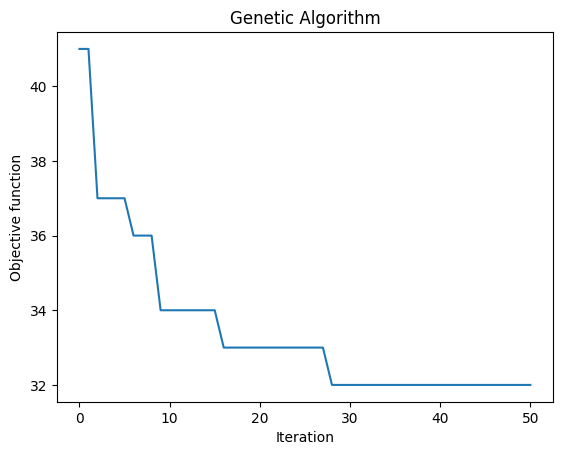

In [24]:
# define parameters
algorithm_param = {'max_num_iteration': 100,\
                   'population_size':1000,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':20}
# define variables
varbound=np.array([[0,25],[0,32],[0,22],[0,18],[0,24],[0,12],[0,14]])
vartype=np.array([['int'],['int'],['int'],['int'],['int'],['int'],['int']])

# define objective function
def f(x):
    cond0 = x[0] + x[3] + x[4] + x[5] + x[6] < 25 
    cond1 = x[0] + x[1] + x[4] + x[5] + x[6] < 32
    cond2 = x[0] + x[1] + x[2] + x[5] + x[6] < 22
    cond3 = x[0] + x[1] + x[2] + x[3] + x[6] < 18
    cond4 = x[0] + x[1] + x[2] + x[3] + x[4] < 24
    cond5 = x[1] + x[2] + x[3] + x[4] + x[5] < 12
    cond6 = x[2] + x[3] + x[4] + x[5] + x[6] < 14
    
    violation0 = x[0] + x[3] + x[4] + x[5] + x[6] - 25
    violation1 = x[0] + x[1] + x[4] + x[5] + x[6] - 32
    violation2 = x[0] + x[1] + x[2] + x[5] + x[6] - 22
    violation3 = x[0] + x[1] + x[2] + x[3] + x[6] - 18
    violation4 = x[0] + x[1] + x[2] + x[3] + x[4] - 24
    violation5 = x[1] + x[2] + x[3] + x[4] + x[5] - 12
    violation6 = x[2] + x[3] + x[4] + x[5] + x[6] - 14
    
    # apply a penalty each time the contraints are met
    if cond0 or cond1 or cond2 or cond3 or cond4 or cond5 or cond6:
        penalty = violation0**2 + violation1**2  + violation2**2  + violation3**2  + violation4**2  + violation5**2  + violation6**2
        return np.sum(x) + penalty
    else:
        return np.sum(x) 

model=ga(function=f,
         dimension=7, # one variable for each day of the week
         variable_type_mixed=vartype,
         variable_boundaries=varbound,
         algorithm_parameters=algorithm_param)

model.run()